In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [3]:
n = 500
g = 3000
k = 20
o = 1

In [4]:
def DFtoDataset(df, scale=False):
    X = df[[str(i) for i in np.arange(n)]].values.T
    if (scale):
        X = preprocessing.scale(X)
        
    binaryPathwayMatrix = df[['pathway{}'.format(i) for i in range(df.shape[1] - n - 2)]].values

    phenotypeGenes = df['phenotype_genes']
    phenotypeGenes = np.where(phenotypeGenes == 1)[0]

    return X, binaryPathwayMatrix, phenotypeGenes

In [16]:
dataFileBase = '/projects/leelab3/psturm/simulatedData/corLatentData/df{}.csv'

In [ ]:
eta, lamb1, lamb2 = 0.017340, 0.002877, 0.014591
eta_nn, lamb1_nn, lamb2_nn = 0.015842, 0.004794, 0.0

In [12]:
numReps = 50
intersectionGap = 1
numPlotPoints = int(g / intersectionGap)

def TrainReps(rep, n, g, k):
    #needs: n, g, k
    df = pd.read_csv(dataFileBase.format(rep))
    X, binaryPathwayMatrix, phenotypeGenes = DFtoDataset(df)
    neighbors = GetNeighborDictionary(binaryPathwayMatrix, percentileThreshold=95)
    pca = PCA(n_components=50)
    projectedX = pca.fit_transform(X.T)
    latent_dim = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
    #Train on all of the data
    U_pred_init, V_pred_init = CreateLatentVariables(n, g, latent_dim)
    U_pred, V_pred           = FactorizeMatrix(X, U_pred_init, V_pred_init, neighbors, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=10)
    U_pred_nn, V_pred_nn     = FactorizeMatrix(X, U_pred_init, V_pred_init, {}, 
                                     eta=eta_nn, lamb1=lamb1_nn, lamb2=lamb2_nn, num_epochs=10)
    
    np.save('/projects/leelab3/psturm/learnedCorrelatedModels/U{}.npy'.format(rep), U_pred)
    np.save('/projects/leelab3/psturm/learnedCorrelatedModels/V{}.npy'.format(rep), V_pred)
    np.save('/projects/leelab3/psturm/learnedCorrelatedModels/Unn{}.npy'.format(rep), U_pred_nn)
    np.save('/projects/leelab3/psturm/learnedCorrelatedModels/Vnn{}.npy'.format(rep), V_pred_nn)

In [ ]:
numProcesses = 20
p = Pool(numProcesses)
p.map(partial(TrainReps, n=n, g=g, k=k), range(numReps))
p.close()
p.join()

In [42]:
def ApplyIntersection(predList, trueList, g, intersectionGap):
    numPlotPoints = int(g / intersectionGap)
    intersection_list = np.zeros((numPlotPoints))
    index = 0
    for i in range(0, g, intersectionGap):
        intersection_list[index] = np.sum(np.in1d(predList[i:i+intersectionGap], trueList))
        index += 1
    return intersection_list
    
def GetIntersections(rep):
    print(rep, end=',')
    df = pd.read_csv(dataFileBase.format(rep))
    X, _, phenotypeGenes = DFtoDataset(df)
    
    U_pred = np.load('/projects/leelab3/psturm/learnedCorrelatedModels/U{}.npy'.format(rep))
    V_pred = np.load('/projects/leelab3/psturm/learnedCorrelatedModels/V{}.npy'.format(rep))
    U_pred_nn = np.load('/projects/leelab3/psturm/learnedCorrelatedModels/Unn{}.npy'.format(rep))
    V_pred_nn = np.load('/projects/leelab3/psturm/learnedCorrelatedModels/Vnn{}.npy'.format(rep))

    intersection_mat = np.zeros((12, numPlotPoints))
    intersection_mat[0, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='dot'),  phenotypeGenes, g, intersectionGap)
    intersection_mat[1, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='corr'), phenotypeGenes, g, intersectionGap)
    intersection_mat[2, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='cos'),  phenotypeGenes, g, intersectionGap)
    intersection_mat[3, :] = ApplyIntersection(GetTopGenes(V_pred, 0, np.arange(1, g), rankType='dist', sortFunc=None), phenotypeGenes, g, intersectionGap)
    
    intersection_mat[4, :] = ApplyIntersection(GetTopGenes(V_pred_nn, 0, np.arange(1, g), rankType='dot'),  phenotypeGenes, g, intersectionGap)
    intersection_mat[5, :] = ApplyIntersection(GetTopGenes(V_pred_nn, 0, np.arange(1, g), rankType='corr'), phenotypeGenes, g, intersectionGap)
    intersection_mat[6, :] = ApplyIntersection(GetTopGenes(V_pred_nn, 0, np.arange(1, g), rankType='cos'),  phenotypeGenes, g, intersectionGap)
    intersection_mat[7, :] = ApplyIntersection(GetTopGenes(V_pred_nn, 0, np.arange(1, g), rankType='dist', sortFunc=None), phenotypeGenes, g, intersectionGap)
    
    intersection_mat[8, :] = ApplyIntersection(GetTopGenes(X.T, 0, np.arange(1, g), rankType='dot'),  phenotypeGenes, g, intersectionGap)
    intersection_mat[9, :] = ApplyIntersection(GetTopGenes(X.T, 0, np.arange(1, g), rankType='corr'), phenotypeGenes, g, intersectionGap)
    intersection_mat[10, :] = ApplyIntersection(GetTopGenes(X.T, 0, np.arange(1, g), rankType='cos'),  phenotypeGenes, g, intersectionGap)
    intersection_mat[11, :] = ApplyIntersection(GetTopGenes(X.T, 0, np.arange(1, g), rankType='dist', sortFunc=None), phenotypeGenes, g, intersectionGap)

    intersection_mat = intersection_mat / len(phenotypeGenes)
    return intersection_mat

In [43]:
tg_zipped = map(GetIntersections, range(numReps))

In [44]:
tg_stacked = np.stack(tg_zipped, axis=0) #of shape numReps, 4, numPlotPoints
tg_summed  = np.cumsum(tg_stacked, axis=2) #cumulative sum over numPlotPoints

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

In [51]:
def plotIndices(tg_summed, names, indices, x_values, ci=None):
    dfs = []
    for i in range(len(indices)):
        dfs.append(MatToMeltDF(tg_summed[:, indices[i], :], group_name = names[i], x_values=x_values))
    sns.lineplot(x='percent identified as significant', y='percent identified actually significant', hue='group', 
             data=pd.concat(dfs), ci=ci)

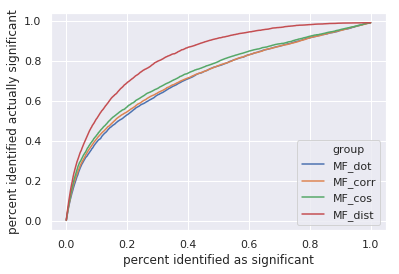

In [46]:
plotIndices(tg_summed, ['MF_dot', 'MF_corr', 'MF_cos', 'MF_dist'], [0, 1, 2, 3], np.arange(int(g))/g)

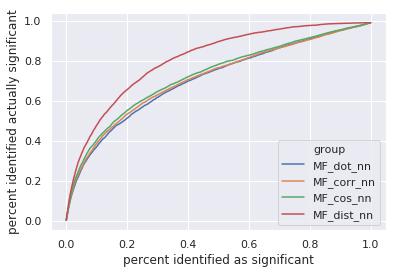

In [47]:
plotIndices(tg_summed, ['MF_dot_nn', 'MF_corr_nn', 'MF_cos_nn', 'MF_dist_nn'], [4, 5, 6, 7], np.arange(int(g))/g)

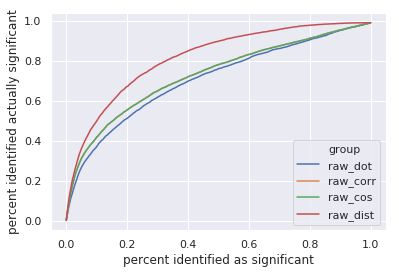

In [48]:
plotIndices(tg_summed, ['raw_dot', 'raw_corr', 'raw_cos', 'raw_dist'], [8, 9, 10, 11], np.arange(int(g))/g)

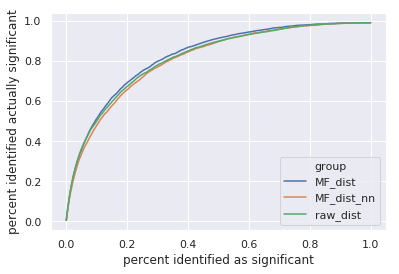

In [53]:
plotIndices(tg_summed, ['MF_dist', 'MF_dist_nn', 'raw_dist'], [3, 7, 11], np.arange(int(g))/g)

In [61]:
x_values = np.arange(int(g)) / g
im_dist_df  = MatToMeltDF(tg_summed[:, 3, :],  group_name='MF_dist', x_values=x_values)
nn_dist_df  = MatToMeltDF(tg_summed[:, 7, :],  group_name='MF_nn_dist', x_values=x_values)
raw_dist_df = MatToMeltDF(tg_summed[:, 11, :], group_name='raw_dist', x_values=x_values)
raw_cor_df  = MatToMeltDF(tg_summed[:, 9, :],  group_name='raw_cor', x_values=x_values)

In [57]:
baseSaveDir = '../../DataFrames/corLatentRegression/{}'
elastic_net_mat = pd.read_csv(baseSaveDir.format('elastic_net.csv')).values.T
elastic_net_df  = MatToMeltDF(elastic_net_mat, group_name='elastic_net', x_values=x_values)

sparse_gl_mat  = pd.read_csv(baseSaveDir.format('sparse_gl.csv')).values.T
sparse_gl_df = MatToMeltDF(sparse_gl_mat, group_name='sparse_gl', x_values=x_values)

In [58]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

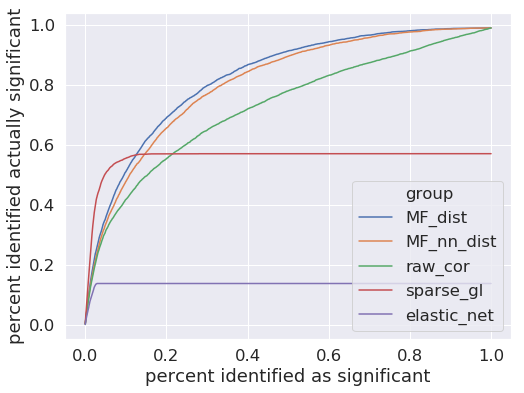

In [79]:
sns.lineplot(x='percent identified as significant', y='percent identified actually significant', hue='group', 
             data=pd.concat([im_dist_df, nn_dist_df, raw_cor_df, sparse_gl_df, elastic_net_df]), ci=None)

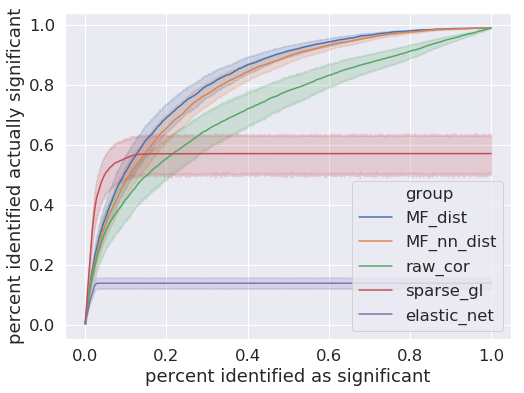

In [81]:
sns.lineplot(x='percent identified as significant', y='percent identified actually significant', hue='group', 
             data=pd.concat([im_dist_df, nn_dist_df, raw_cor_df, sparse_gl_df, elastic_net_df]), ci=95)

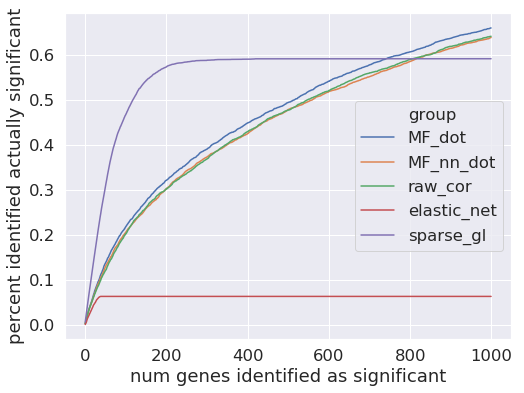

In [42]:
sns.lineplot(x='percent identified as significant', y='percent identified actually significant', hue='group', 
             data=pd.concat([im_dot_df, nn_dot_df, raw_cor_df, elastic_net_df, sparse_gl_df]), ci=None)